In [1]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import os
import seaborn as sns
import seaborn.objects as so

from pathlib import Path
import re
from typing import TypedDict
import numpy as np

os.environ["POLARS_MAX_THREADS"] = "128"

import polars as pl

In [2]:
%load_ext watermark
%watermark -vp seaborn,numpy,polars,tensorboard,pandas,pyarrow

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.13.2

seaborn    : 0.12.2
numpy      : 1.23.5
polars     : 0.20.6
tensorboard: 2.16.2
pandas     : 2.0.1
pyarrow    : 11.0.0



Note above that `pandas` and `pyarrow` need to be installed for a rolling slope calculation below.

In [3]:
whitespace = re.compile(r'\s+')
class Metadata(TypedDict):
    hidden_dims: tuple[int, int]
    num_layers: int
    lr: float
    disjoint_train_ratio: float
    share_weights: bool


def extract_hyperparams(file: str | Path) -> Metadata:
    metadata: Metadata = {} # type: ignore
    with open(file) as fp:
        since_hidden_dims = 0
        hidden_dims = []
        for line in fp:
            fields = [x for x in whitespace.split(line) if x]

            if since_hidden_dims == 2:
                hidden_dims.append(int(fields[-1]))
                metadata["hidden_dims"] = tuple(hidden_dims)
                since_hidden_dims = 0
            elif since_hidden_dims == 1:
                hidden_dims.append(int(fields[-1]))
                since_hidden_dims += 1

            if "hidden_dims: !!python/tuple" in line:
                since_hidden_dims += 1
            elif "num_layers" in line:
                metadata["num_layers"] = int(fields[-1])
            elif "lr" in line:
                metadata["lr"] = float(fields[-1])
            elif "disjoint_train_ratio" in line:
                metadata["disjoint_train_ratio"] = float(fields[-1])
            elif "share_weights" in line:
                metadata["share_weights"] = fields[-1] == "true"
    return metadata

In [4]:
hparams = ["hidden_dims", "disjoint_train_ratio", "num_layers", "lr", "share_weights"]

In [5]:
summary_dict = {
    "dataset": [],
    "stage": [],
    "epoch": [],
    "value": [],
    "metric": [],
    "version": []
}

for key in hparams:
    summary_dict[key] = []

# we did NOT prodive the intermediate models since they are large (>70GB in total)
# but these can be generated using the code in this repo
for file in Path("intermediate_trained_models").rglob("*events*"):
    dataset = file.parent.parent.parent.name.split("_", 1)[0]
    hparams_file = file.parent.joinpath("hparams.yaml")
    version = file.parent.name
    metadata = extract_hyperparams(hparams_file)
    accumulator = EventAccumulator(file.as_posix())
    accumulator.Reload()

    if "val_loss" not in accumulator.Tags()["scalars"]:
        continue

    for stage in ["train", "val"]:
        for metric in ["loss", "acc"]:
            for record in accumulator.Scalars(f"{stage}_{metric}"):
                summary_dict["dataset"].append(dataset)
                summary_dict["stage"].append(stage)
                summary_dict["metric"].append(metric)
                summary_dict["epoch"].append(record.step)
                summary_dict["value"].append(record.value)
                summary_dict["version"].append(version)
                for key, value in metadata.items():
                    summary_dict[key].append(value)

summary = (
    pl.DataFrame(summary_dict)
    # smooth values over 3 epochs
    .rolling("epoch", period="3i", by=["dataset", "version", "stage", "metric"])
    .agg(
        pl.mean("value"), 
        pl.first(
            "hidden_dims", 
            "num_layers", 
            "lr", 
            "disjoint_train_ratio", 
            "share_weights"
        ),
    )
)

summary

dataset,version,stage,metric,epoch,value,hidden_dims,num_layers,lr,disjoint_train_ratio,share_weights
str,str,str,str,i64,f64,list[i64],i64,f64,f64,bool
"""esm-large""","""version_205""","""train""","""loss""",0,0.691553,"[128, 64]",2,0.0005,0.0,false
"""esm-large""","""version_205""","""train""","""loss""",1,0.690258,"[128, 64]",2,0.0005,0.0,false
"""esm-large""","""version_205""","""train""","""loss""",2,0.688978,"[128, 64]",2,0.0005,0.0,false
"""esm-large""","""version_205""","""train""","""loss""",3,0.686871,"[128, 64]",2,0.0005,0.0,false
"""esm-large""","""version_205""","""train""","""loss""",4,0.684731,"[128, 64]",2,0.0005,0.0,false
"""esm-large""","""version_205""","""train""","""loss""",5,0.682457,"[128, 64]",2,0.0005,0.0,false
"""esm-large""","""version_205""","""train""","""loss""",6,0.67962,"[128, 64]",2,0.0005,0.0,false
"""esm-large""","""version_205""","""train""","""loss""",7,0.675821,"[128, 64]",2,0.0005,0.0,false
"""esm-large""","""version_205""","""train""","""loss""",8,0.671265,"[128, 64]",2,0.0005,0.0,false


In [6]:
def rolling_slope(summary: pl.DataFrame) -> pl.DataFrame:
    dfs: list[pl.DataFrame] = []
    groups = (
        summary
        # rolling slope over validation loss
        .filter(
            pl.col("stage").eq("val") &
            pl.col("metric").eq("loss")
        )
        .partition_by("dataset", "version")
    )
    
    for df in groups:
        rolling_slope_ = (
            df
            .to_pandas()
            .set_index("epoch")
            .rolling(window=5)
            ["value"]
            .apply(
                lambda x: np.polyfit(x.index, x, 1)[0]
            )
            .to_numpy()
        )

        dfs.append(
            df.with_columns(rolling_slope=rolling_slope_)
        )
    
    return pl.concat(dfs)

def filter_good_performance(summary: pl.DataFrame, tolerance: float = 0.005) -> pl.DataFrame:
    filtered_versions = (
        rolling_slope(summary)
        .filter(pl.col("rolling_slope").is_not_nan())
        .with_columns(
            is_decreasing = (
                pl.col("rolling_slope")
                .lt(tolerance)
                .all()
                .over("dataset", "version")
            ),
        )
        .filter(pl.col("is_decreasing"))
        .select("dataset", "version")
        .unique()
    )

    return (
        summary
        .join(filtered_versions, on=filtered_versions.columns)
        .filter(
            pl.col("metric").eq("loss") & 
            pl.col("stage").eq("val")
        )
    )

In [7]:
filtered_summary = filter_good_performance(summary)
filtered_summary

dataset,version,stage,metric,epoch,value,hidden_dims,num_layers,lr,disjoint_train_ratio,share_weights
str,str,str,str,i64,f64,list[i64],i64,f64,f64,bool
"""esm-large""","""version_96""","""val""","""loss""",0,0.688155,"[128, 32]",1,0.0005,0.0,true
"""esm-large""","""version_96""","""val""","""loss""",1,0.687764,"[128, 32]",1,0.0005,0.0,true
"""esm-large""","""version_96""","""val""","""loss""",2,0.687,"[128, 32]",1,0.0005,0.0,true
"""esm-large""","""version_96""","""val""","""loss""",3,0.685518,"[128, 32]",1,0.0005,0.0,true
"""esm-large""","""version_96""","""val""","""loss""",4,0.683647,"[128, 32]",1,0.0005,0.0,true
"""esm-large""","""version_96""","""val""","""loss""",5,0.681585,"[128, 32]",1,0.0005,0.0,true
"""esm-large""","""version_96""","""val""","""loss""",6,0.679264,"[128, 32]",1,0.0005,0.0,true
"""esm-large""","""version_96""","""val""","""loss""",7,0.67684,"[128, 32]",1,0.0005,0.0,true
"""esm-large""","""version_96""","""val""","""loss""",8,0.674272,"[128, 32]",1,0.0005,0.0,true


In [8]:
best_models = pl.concat(
    [
        df.bottom_k(k=1, by="value")
        for df in (
            filtered_summary
            .filter(pl.col("lr").lt(0.005))
            .partition_by("dataset")
        )
    ]
).with_columns(best=True)

best_models

dataset,version,stage,metric,epoch,value,hidden_dims,num_layers,lr,disjoint_train_ratio,share_weights,best
str,str,str,str,i64,f64,list[i64],i64,f64,f64,bool,bool
"""esm-large""","""version_331""","""val""","""loss""",148,0.159109,"[128, 64]",3,0.001,0.3,false,true
"""cherry""","""version_8""","""val""","""loss""",146,0.317423,"[128, 32]",2,0.001,0.0,true,true
"""kmer""","""version_150""","""val""","""loss""",147,0.193592,"[256, 128]",3,0.001,0.3,true,true
"""pst-large""","""version_339""","""val""","""loss""",139,0.195755,"[128, 32]",3,0.0005,0.3,false,true


Just for a sense of what models were chosen, here is a plot of **validation loss** over training time. This is **Extended Data Figure 9** in the manuscript.

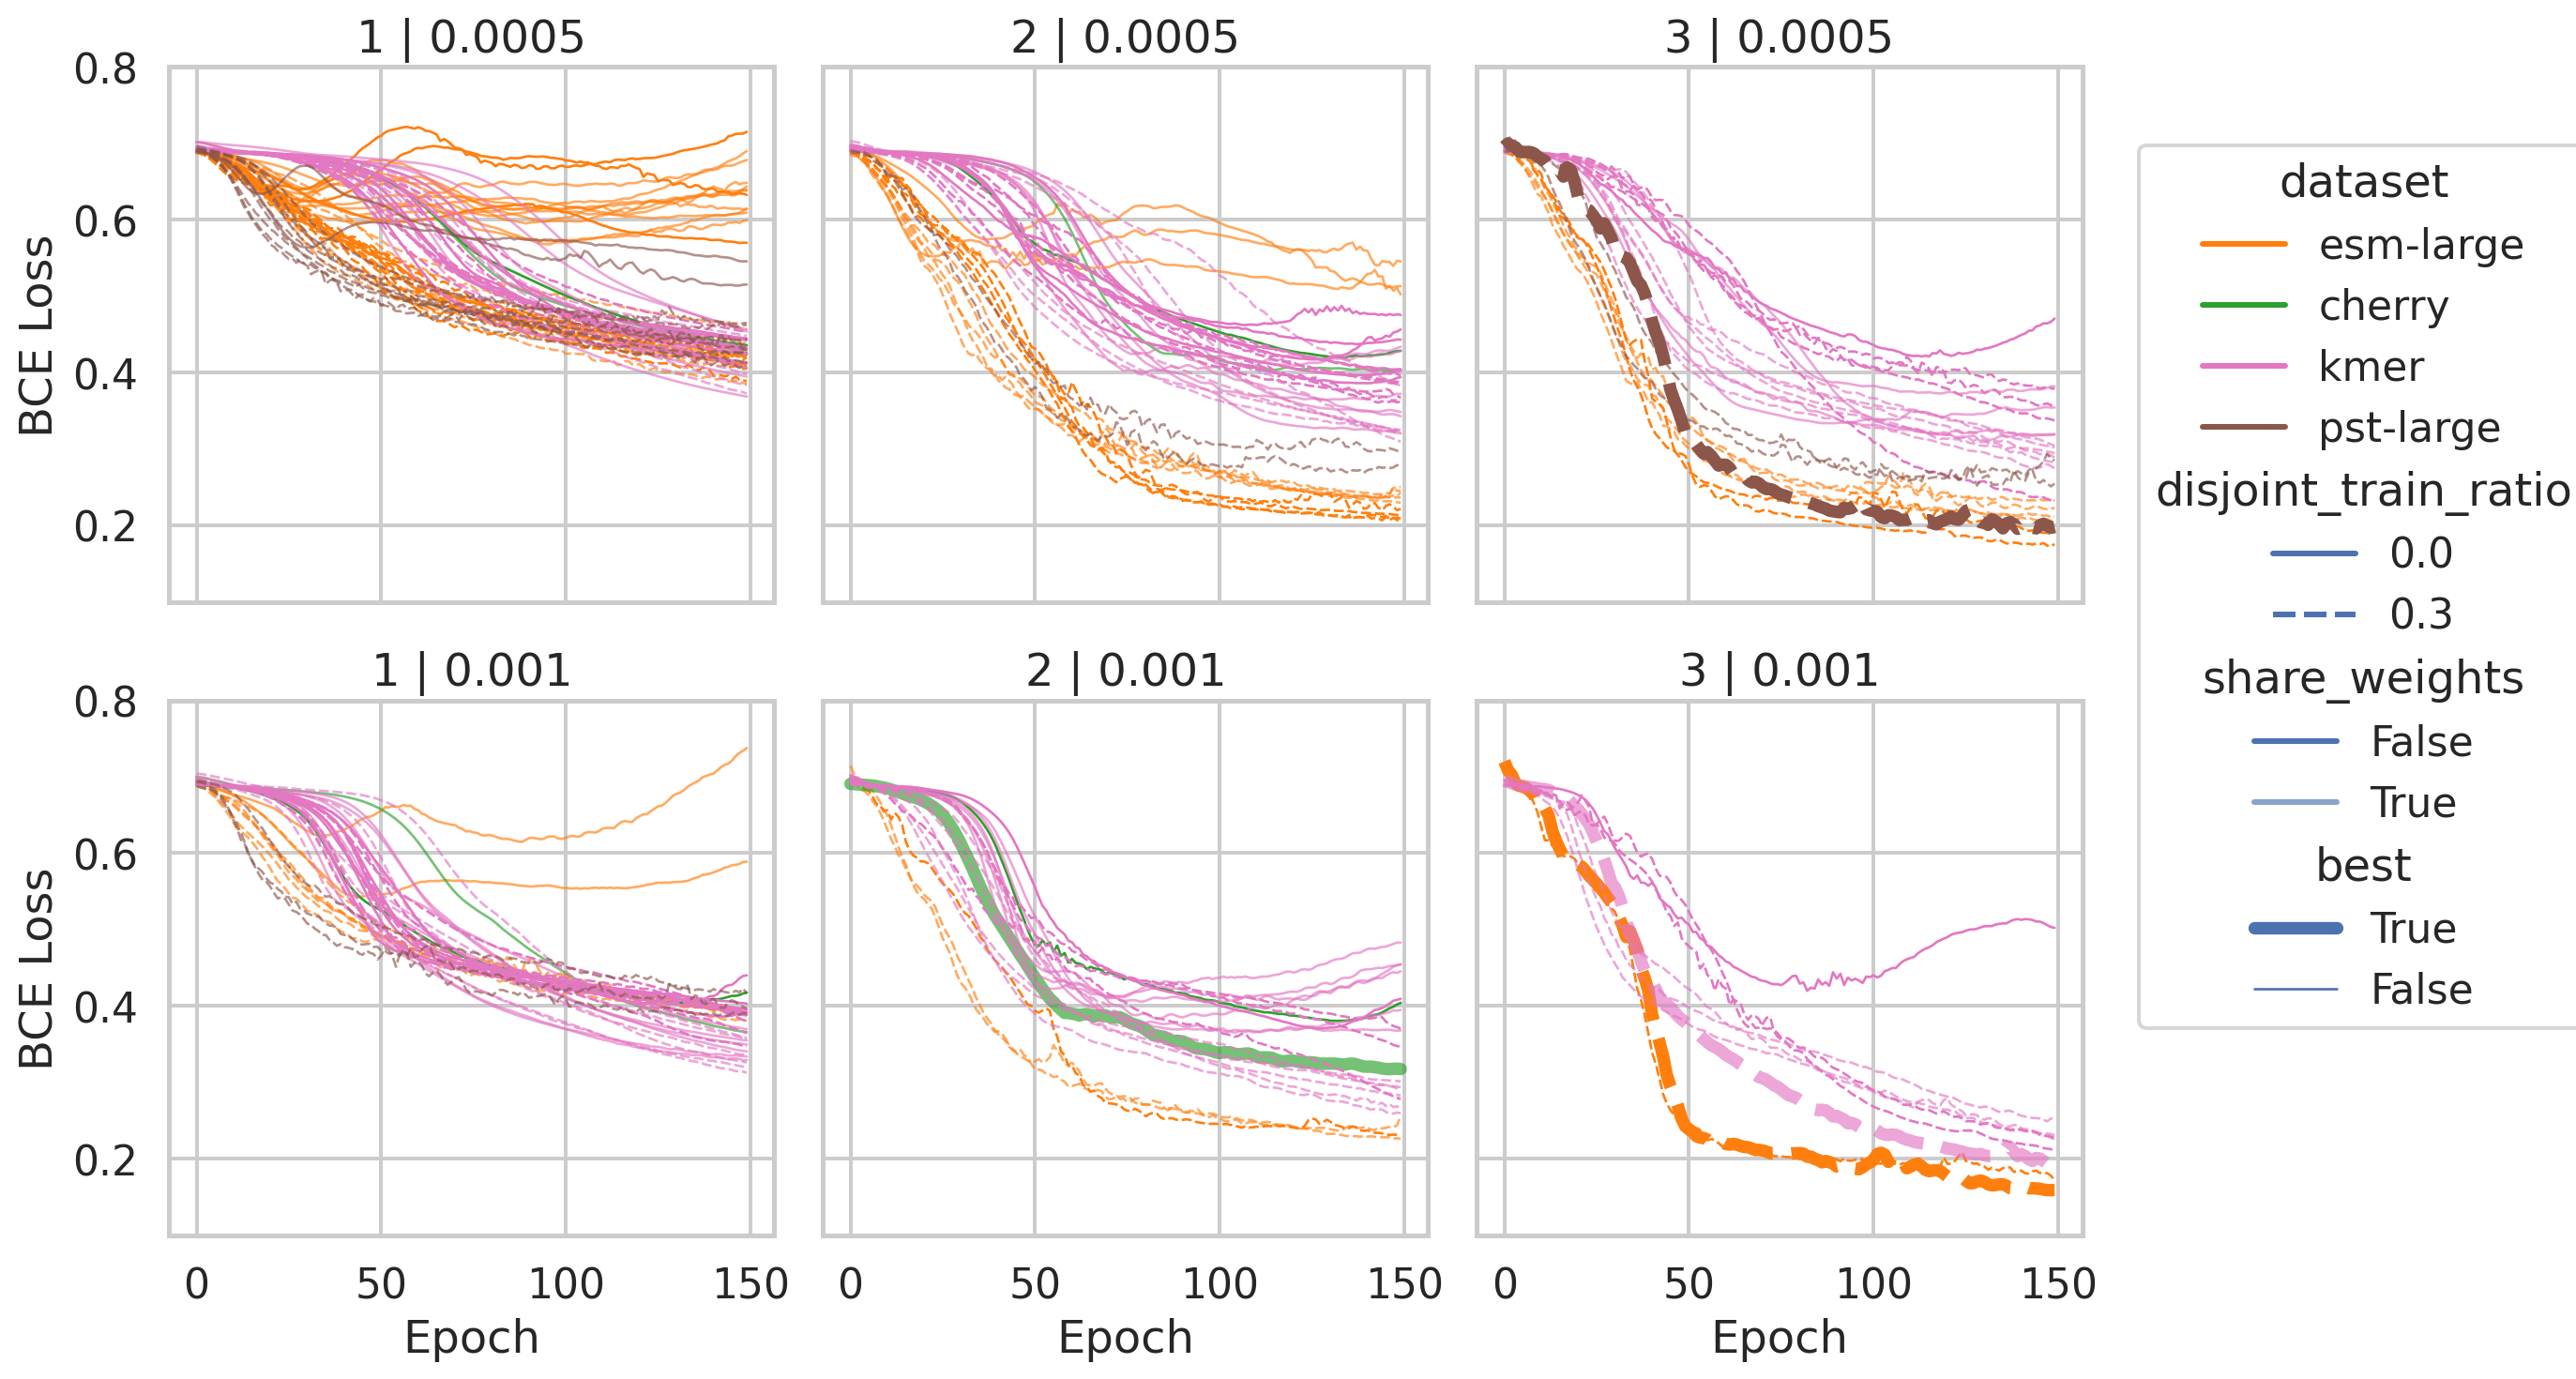

In [9]:
colors = {
    "esm-large": "tab:orange",
    "pst-large": "tab:brown",
    "kmer": "tab:pink",
    "cherry": "tab:green",
}

(
    so.Plot(
        data=(
            filtered_summary
            .filter(pl.col("lr").lt(0.005))
            .join(best_models.select("dataset", "version", "best"), on=["dataset", "version"], how="left")
            .with_columns(
                pl.col("best").fill_null(False),
                plot_hidden_dims = pl.col("hidden_dims").list.sum()
            )
        ),
        x="epoch",
        y="value",
        color="dataset",
        linestyle="disjoint_train_ratio",
        group="plot_hidden_dims",
        alpha="share_weights",
        linewidth="best",
    )
    .facet(col="num_layers", row="lr")
    .add(so.Line())
    .layout(size=(12, 8))
    .theme(sns.axes_style("whitegrid") | sns.plotting_context("talk"))
    .scale(
        # color=so.Nominal(values="tab10", order=["esm-large", "pst-large", "kmer", "cherry"]),
        color=colors,
        alpha=so.Nominal(values=[1.0, 0.65], order=[False, True]),
        linewidth={True: 5, False: 1}
    )
    .limit(y=(0.1, 0.8))
    .label(y="BCE Loss", x="Epoch")
)